# 패키지 임포트

In [1]:
import json
import os
import requests
from konlpy.tag import Okt

import torch
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# tokenizers 병렬 처리 충돌 방지
os.environ["TOKENIZERS_PARALLELISM"] = "false"

/opt/homebrew/anaconda3/envs/preprocessing/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 설정 및 초기화

In [2]:
model_ckpt = 'gogamza/kobart-base-v2'
output_dir = "./kobart_korean_summarize_model"

# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


# 데이터 전처리

### 원본 데이터셋 로드

In [38]:
with open('./newspaper_summarize_jsonl/newspaper_summarize.jsonl') as f:
	dataset = [json.loads(line) for line in f]
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42, shuffle=True)
valid_dataset, test_dataset = train_test_split(test_dataset, test_size=0.5, random_state=42, shuffle=True)

### 전처리된 데이터셋 로드

In [11]:
with open('./cleaned_datasets/cleaned_train_dataset.json') as f:
	train_dataset = [data for data in json.load(f)]
with open('./cleaned_datasets/cleaned_valid_dataset.json') as f:
	valid_dataset = [data for data in json.load(f)]
with open('./cleaned_datasets/cleaned_test_dataset.json') as f:
	test_dataset = [data for data in json.load(f)]

In [13]:
import matplotlib.pyplot as plt

In [27]:
def tokenize_summarize_dataset(dataset):
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt, force_download=True)
    body_tokens = []
    summarize_tokens = []
    for data in dataset:
        if (len(data['body']) > 0 and len(data['summarize']) > 0):
            body_tokens.append(tokenizer(data['body']))
            summarize_tokens.append(tokenizer(data['summarize']))
    return {'body': body_tokens, 'summarize': summarize_tokens}

def plot_bar_chart(categories, values, title='Bar Chart', xlabel='Categories', 
                   ylabel='Values', color='skyblue', figsize=(10, 6), 
                   show_values=True, save_path=None):
    """
    matplotlib를 사용하여 Bar 차트를 그리는 함수
    
    Parameters:
    -----------
    categories : list or array-like
        x축에 표시될 카테고리 이름들
    values : list or array-like
        각 카테고리에 해당하는 값들
    title : str, optional
        차트 제목 (기본값: 'Bar Chart')
    xlabel : str, optional
        x축 레이블 (기본값: 'Categories')
    ylabel : str, optional
        y축 레이블 (기본값: 'Values')
    color : str or list, optional
        바의 색상 (기본값: 'skyblue')
    figsize : tuple, optional
        그래프 크기 (기본값: (10, 6))
    show_values : bool, optional
        바 위에 값 표시 여부 (기본값: True)
    save_path : str, optional
        그래프를 저장할 경로 (기본값: None, 저장하지 않음)
    
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """
    
    # 그래프 생성
    fig, ax = plt.subplots(figsize=figsize)
    
    # Bar 차트 그리기
    bars = ax.bar(categories, values, color=color, edgecolor='black', linewidth=0.7)
    
    # 제목과 레이블 설정
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    
    # 그리드 추가 (y축만)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    
    # 레이아웃 조정
    plt.tight_layout()
    
    # 그래프 저장 (경로가 지정된 경우)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"그래프가 {save_path}에 저장되었습니다.")
    
    return fig, ax

def plot_boxplot(data, labels=None, title='Box Plot', xlabel='Categories', 
                 ylabel='Values', color='lightblue', figsize=(10, 6), 
                 show_outliers=True, show_mean=False, save_path=None):
    """
    matplotlib를 사용하여 Box Plot을 그리는 함수
    
    Parameters:
    -----------
    data : list of array-like or 2D array
        박스플롯을 그릴 데이터. 각 그룹별 데이터의 리스트 또는 2D 배열
    labels : list, optional
        각 박스의 레이블 (기본값: None, 자동으로 번호 생성)
    title : str, optional
        차트 제목 (기본값: 'Box Plot')
    xlabel : str, optional
        x축 레이블 (기본값: 'Categories')
    ylabel : str, optional
        y축 레이블 (기본값: 'Values')
    color : str or list, optional
        박스의 색상 (기본값: 'lightblue')
    figsize : tuple, optional
        그래프 크기 (기본값: (10, 6))
    show_outliers : bool, optional
        이상치 표시 여부 (기본값: True)
    show_mean : bool, optional
        평균값 표시 여부 (기본값: False)
    save_path : str, optional
        그래프를 저장할 경로 (기본값: None, 저장하지 않음)
    
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """
    
    # 그래프 생성
    fig, ax = plt.subplots(figsize=figsize)
    
    # 박스플롯 그리기
    bp = ax.boxplot(data, 
                    labels=labels,
                    patch_artist=True,
                    showfliers=show_outliers,
                    showmeans=show_mean,
                    meanprops=dict(marker='o', markerfacecolor='red', markeredgecolor='red', markersize=8))
    
    # 박스 색상 설정
    if isinstance(color, str):
        for patch in bp['boxes']:
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
    elif isinstance(color, list):
        for patch, col in zip(bp['boxes'], color):
            patch.set_facecolor(col)
            patch.set_alpha(0.7)
    
    # 제목과 레이블 설정
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    
    # 그리드 추가 (y축만)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    
    # 레이아웃 조정
    plt.tight_layout()
    
    # 그래프 저장 (경로가 지정된 경우)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"그래프가 {save_path}에 저장되었습니다.")
    
    return fig, ax

def describe_statistics(data, title=None, decimals=2):
    """
    데이터의 기술통계를 계산하고 출력하는 개선된 함수
    
    Parameters:
    -----------
    data : list or array-like
        분석할 데이터
    title : str, optional
        출력할 제목 (기본값: None)
    decimals : int, optional
        소수점 자릿수 (기본값: 2)
    
    Returns:
    --------
    dict : 계산된 통계값들을 포함한 딕셔너리
    """
    import numpy as np
    
    if title:
        print(f"\n=== {title} ===")
    
    data = np.array(data)
    n = len(data)
    
    # 기본 통계값 계산
    mean_val = np.mean(data)
    median_val = np.median(data)
    std_val = np.std(data, ddof=1)  # 표본 표준편차
    var_val = np.var(data, ddof=1)  # 표본 분산
    min_val = np.min(data)
    max_val = np.max(data)
    
    # 사분위수 계산
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    
    # 왜도와 첨도 계산
    from scipy import stats
    skewness = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    
    # 결과 출력
    print(f"{'관측값 개수':<12}: {n}")
    print(f"{'평균':<12}: {mean_val:.{decimals}f}")
    print(f"{'중앙값':<12}: {median_val:.{decimals}f}")
    print(f"{'표준편차':<12}: {std_val:.{decimals}f}")
    print(f"{'분산':<12}: {var_val:.{decimals}f}")
    print(f"{'최솟값':<12}: {min_val:.{decimals}f}")
    print(f"{'최댓값':<12}: {max_val:.{decimals}f}")
    print(f"{'범위':<12}: {max_val - min_val:.{decimals}f}")
    print(f"{'1사분위수':<12}: {q1:.{decimals}f}")
    print(f"{'3사분위수':<12}: {q3:.{decimals}f}")
    print(f"{'사분위범위':<12}: {iqr:.{decimals}f}")
    print(f"{'왜도':<12}: {skewness:.{decimals}f}")
    print(f"{'첨도':<12}: {kurtosis:.{decimals}f}")
    
    # 분포 해석
    print(f"\n📊 분포 특성:")
    if abs(skewness) < 0.5:
        print("  - 분포: 거의 대칭적")
    elif skewness > 0.5:
        print("  - 분포: 오른쪽 꼬리가 긴 분포 (양의 왜도)")
    else:
        print("  - 분포: 왼쪽 꼬리가 긴 분포 (음의 왜도)")
    
    if abs(kurtosis) < 0.5:
        print("  - 첨도: 정규분포와 유사")
    elif kurtosis > 0.5:
        print("  - 첨도: 정규분포보다 뾰족함 (높은 첨도)")
    else:
        print("  - 첨도: 정규분포보다 평평함 (낮은 첨도)")
    
    return {
        'count': n,
        'mean': mean_val,
        'median': median_val,
        'std': std_val,
        'var': var_val,
        'min': min_val,
        'max': max_val,
        'range': max_val - min_val,
        'q1': q1,
        'q3': q3,
        'iqr': iqr,
        'skewness': skewness,
        'kurtosis': kurtosis
    }

In [39]:
train_tokens = tokenize_summarize_dataset(train_dataset)
valid_tokens = tokenize_summarize_dataset(valid_dataset)
test_tokens = tokenize_summarize_dataset(test_dataset)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


In [40]:
# train 데이터셋 본문, 요약문 토큰 크기 확인
length_train_body_tokens = [sum([len(input_ids) for input_ids in body['input_ids']]) for body in train_tokens['body']]
length_train_summarize_tokens = [len(summarize['input_ids']) for summarize in train_tokens['summarize']]


=== 훈련 데이터셋 '본문' 토큰 크기 기술통계 ===
관측값 개수      : 219282
평균          : 434.73
중앙값         : 404.00
표준편차        : 128.62
분산          : 16542.71
최솟값         : 140.00
최댓값         : 6787.00
범위          : 6647.00
1사분위수       : 334.00
3사분위수       : 510.00
사분위범위       : 176.00
왜도          : 1.48
첨도          : 27.44

📊 분포 특성:
  - 분포: 오른쪽 꼬리가 긴 분포 (양의 왜도)
  - 첨도: 정규분포보다 뾰족함 (높은 첨도)


/var/folders/43/8b71k59j78z4lwh9g6x5c2ph0000gn/T/ipykernel_46417/1291496107.py:106: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data,


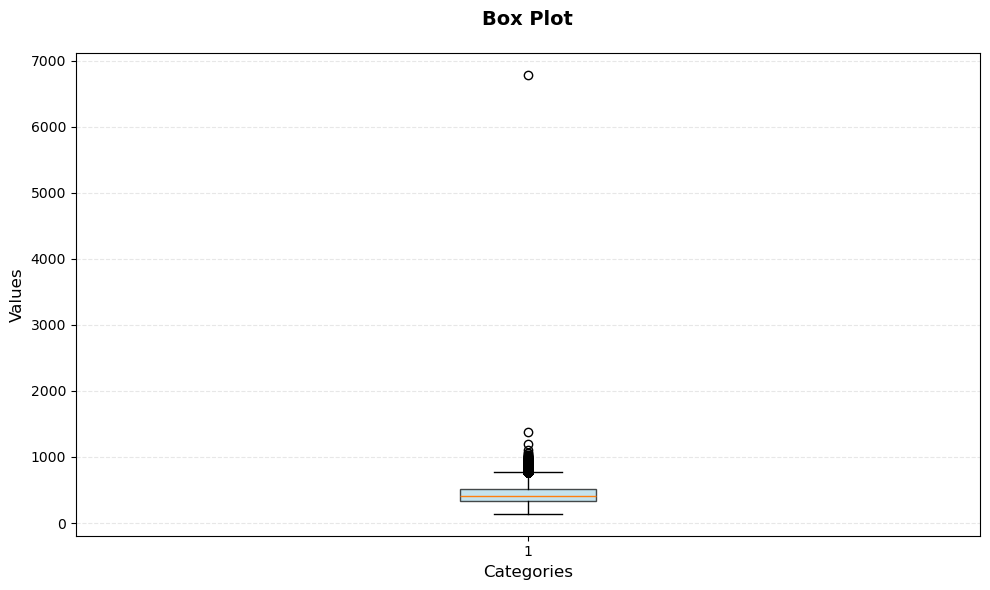


=== 훈련 데이터셋 '요약문' 토큰 크기 기술통계 ===
관측값 개수      : 219282
평균          : 54.89
중앙값         : 53.00
표준편차        : 15.83
분산          : 250.44
최솟값         : 4.00
최댓값         : 299.00
범위          : 295.00
1사분위수       : 44.00
3사분위수       : 64.00
사분위범위       : 20.00
왜도          : 0.80
첨도          : 2.20

📊 분포 특성:
  - 분포: 오른쪽 꼬리가 긴 분포 (양의 왜도)
  - 첨도: 정규분포보다 뾰족함 (높은 첨도)


/var/folders/43/8b71k59j78z4lwh9g6x5c2ph0000gn/T/ipykernel_46417/1291496107.py:106: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data,


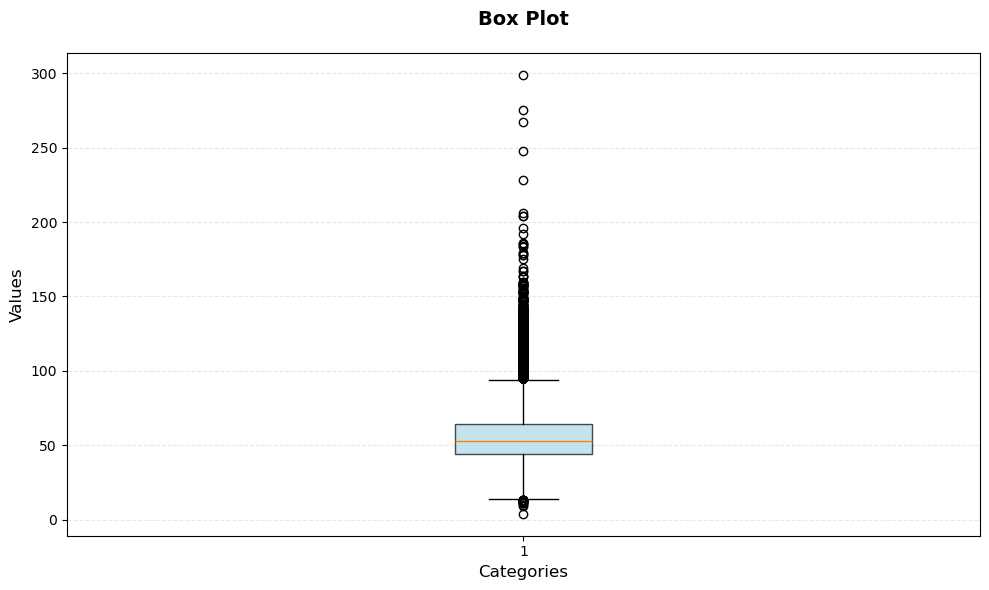

In [41]:
describe_statistics(length_train_body_tokens, title="훈련 데이터셋 '본문' 토큰 크기 기술통계")

fig, ax = plot_boxplot(length_train_body_tokens)
plt.show()

describe_statistics(length_train_summarize_tokens, title="훈련 데이터셋 '요약문' 토큰 크기 기술통계")

fig, ax = plot_boxplot(length_train_summarize_tokens)
plt.show()

In [42]:
# validation 데이터셋 본문, 요약문 토큰 크기 확인
length_valid_body_tokens = [sum([len(input_ids) for input_ids in body['input_ids']]) for body in valid_tokens['body']]
length_valid_summarize_tokens = [len(summarize['input_ids']) for summarize in valid_tokens['summarize']]


=== 검증 데이터셋 '본문' 토큰 크기 기술통계 ===
관측값 개수      : 27409
평균          : 434.35
중앙값         : 404.00
표준편차        : 126.93
분산          : 16110.11
최솟값         : 189.00
최댓값         : 1031.00
범위          : 842.00
1사분위수       : 334.00
3사분위수       : 511.00
사분위범위       : 177.00
왜도          : 0.91
첨도          : 0.30

📊 분포 특성:
  - 분포: 오른쪽 꼬리가 긴 분포 (양의 왜도)
  - 첨도: 정규분포와 유사


/var/folders/43/8b71k59j78z4lwh9g6x5c2ph0000gn/T/ipykernel_46417/1291496107.py:106: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data,


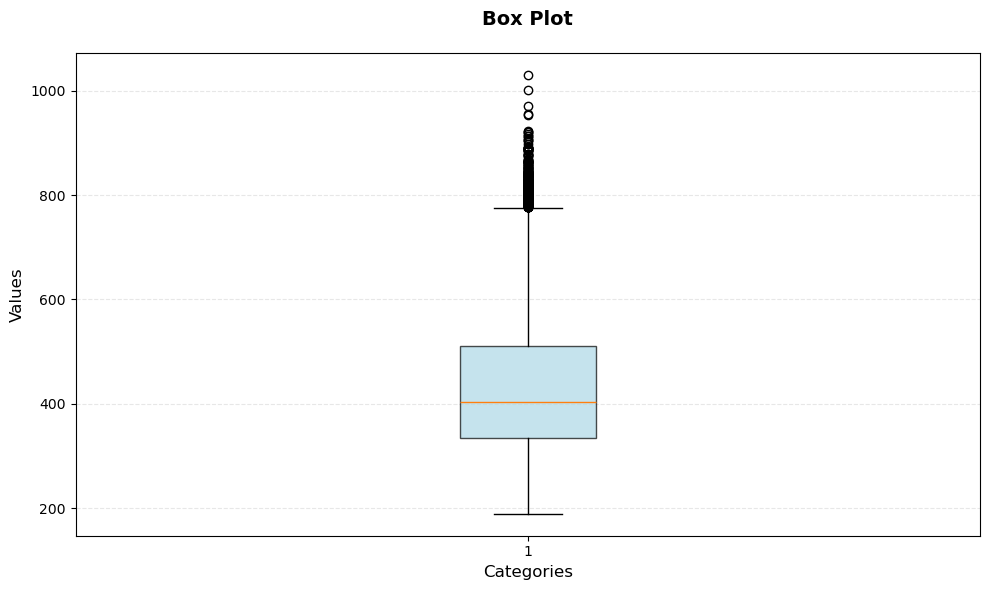


=== 검증 데이터셋 '요약문' 토큰 크기 기술통계 ===
관측값 개수      : 27409
평균          : 54.91
중앙값         : 53.00
표준편차        : 16.02
분산          : 256.52
최솟값         : 9.00
최댓값         : 319.00
범위          : 310.00
1사분위수       : 44.00
3사분위수       : 64.00
사분위범위       : 20.00
왜도          : 0.99
첨도          : 4.74

📊 분포 특성:
  - 분포: 오른쪽 꼬리가 긴 분포 (양의 왜도)
  - 첨도: 정규분포보다 뾰족함 (높은 첨도)


/var/folders/43/8b71k59j78z4lwh9g6x5c2ph0000gn/T/ipykernel_46417/1291496107.py:106: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data,


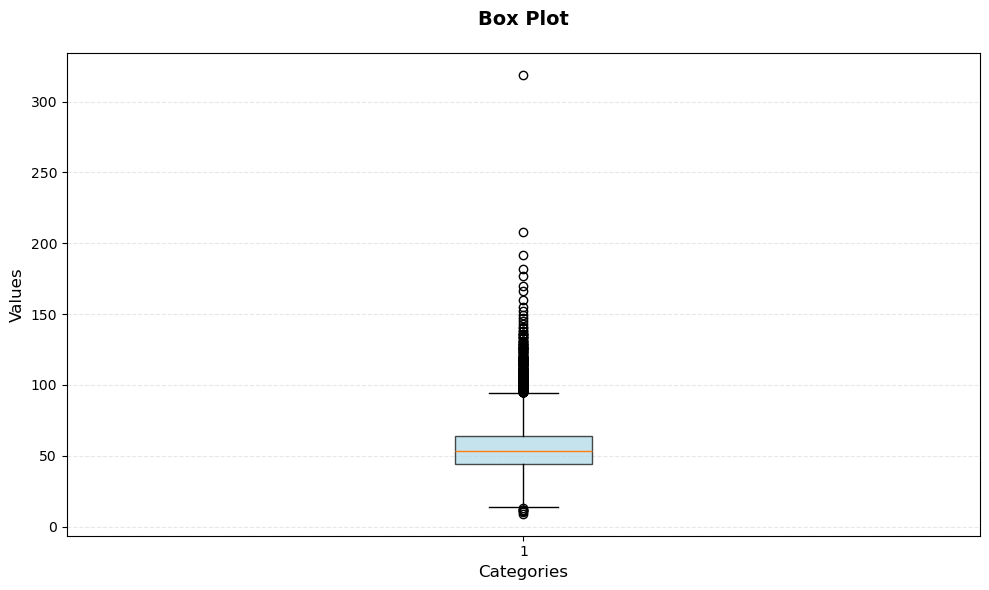

In [43]:
describe_statistics(length_valid_body_tokens, title="검증 데이터셋 '본문' 토큰 크기 기술통계")

fig, ax = plot_boxplot(length_valid_body_tokens)
plt.show()

describe_statistics(length_valid_summarize_tokens, title="검증 데이터셋 '요약문' 토큰 크기 기술통계")

fig, ax = plot_boxplot(length_valid_summarize_tokens)
plt.show()

In [44]:
# test 데이터셋 본문, 요약문 토큰 크기 확인
length_test_body_tokens = [sum([len(input_ids) for input_ids in body['input_ids']]) for body in test_tokens['body']]
length_test_summarize_tokens = [len(summarize['input_ids']) for summarize in test_tokens['summarize']]


=== 테스트 데이터셋 '본문' 토큰 크기 기술통계 ===
관측값 개수      : 27410
평균          : 435.37
중앙값         : 405.00
표준편차        : 128.44
분산          : 16497.05
최솟값         : 197.00
최댓값         : 1143.00
범위          : 946.00
1사분위수       : 334.00
3사분위수       : 509.75
사분위범위       : 175.75
왜도          : 0.97
첨도          : 0.51

📊 분포 특성:
  - 분포: 오른쪽 꼬리가 긴 분포 (양의 왜도)
  - 첨도: 정규분포보다 뾰족함 (높은 첨도)

=== 테스트 데이터셋 '요약문' 토큰 크기 기술통계 ===


/var/folders/43/8b71k59j78z4lwh9g6x5c2ph0000gn/T/ipykernel_46417/1291496107.py:106: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data,
/var/folders/43/8b71k59j78z4lwh9g6x5c2ph0000gn/T/ipykernel_46417/1291496107.py:106: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data,


관측값 개수      : 27410
평균          : 54.85
중앙값         : 53.00
표준편차        : 15.88
분산          : 252.26
최솟값         : 6.00
최댓값         : 214.00
범위          : 208.00
1사분위수       : 44.00
3사분위수       : 64.00
사분위범위       : 20.00
왜도          : 0.81
첨도          : 1.81

📊 분포 특성:
  - 분포: 오른쪽 꼬리가 긴 분포 (양의 왜도)
  - 첨도: 정규분포보다 뾰족함 (높은 첨도)


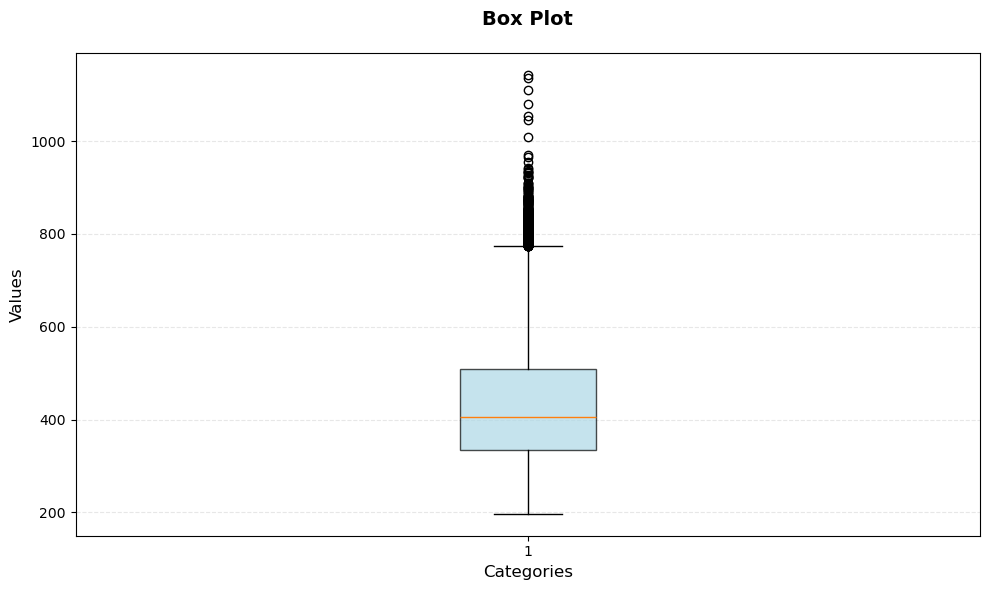

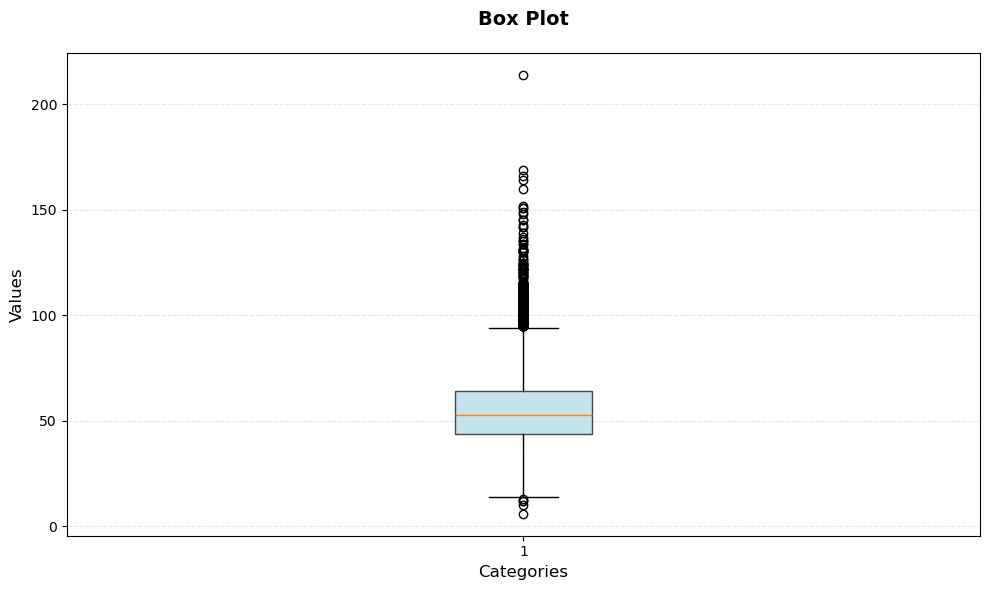

In [45]:
describe_statistics(length_test_body_tokens, title="테스트 데이터셋 '본문' 토큰 크기 기술통계")
fig, ax = plot_boxplot(length_test_body_tokens)

describe_statistics(length_test_summarize_tokens, title="테스트 데이터셋 '요약문' 토큰 크기 기술통계")
fig, ax = plot_boxplot(length_test_summarize_tokens)